Generated some test data to play around with. Lets first plot some of the data to see how it looks like.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from darts import TimeSeries

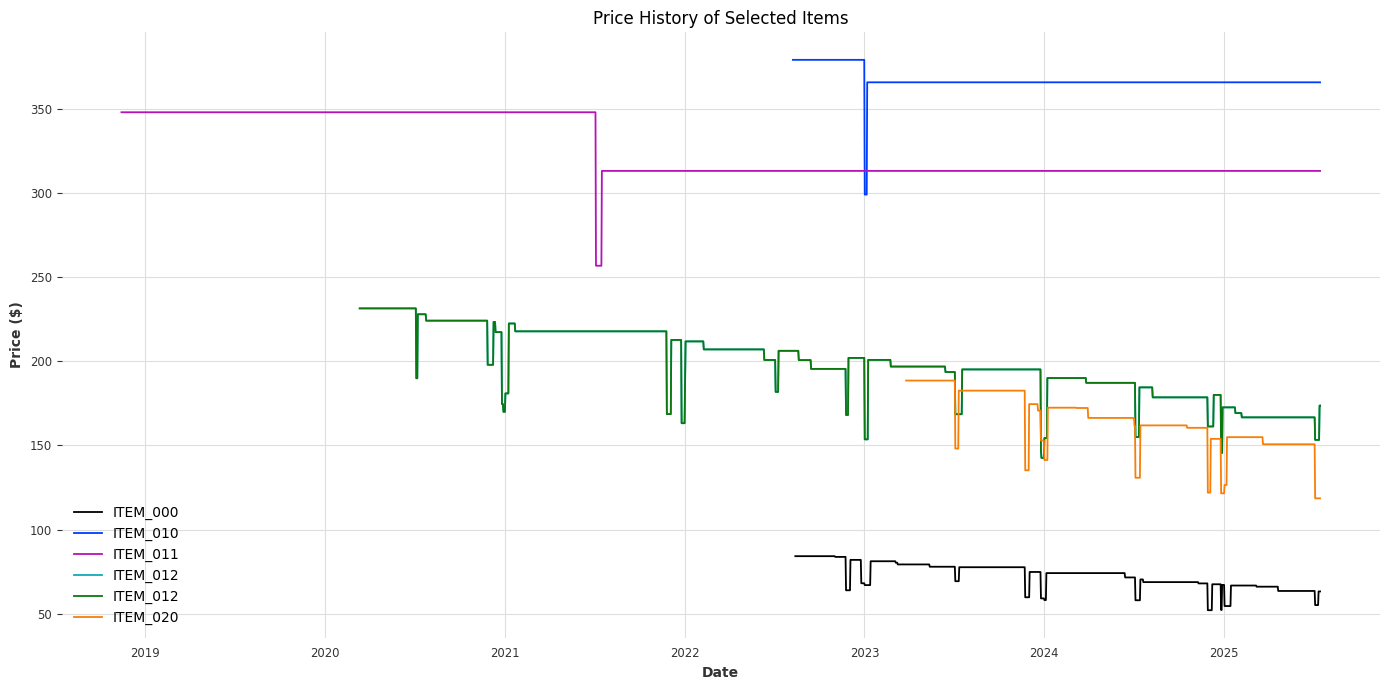

In [31]:
# Load the data
df = pd.read_csv("mock_keepa_data_improved.csv", parse_dates=['date'])

# Function to plot selected item(s)
def plot_items(item_ids):
    plt.figure(figsize=(14, 7))

    for item_id in item_ids:
        item_data = df[df['item_id'] == item_id]
        plt.plot(item_data['date'], item_data['price'], label=item_id)

    plt.title("Price History of Selected Items")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

items_to_plot = ["ITEM_000", "ITEM_010","ITEM_011","ITEM_012","ITEM_012", "ITEM_020"]  # Change these to see different items
plot_items(items_to_plot)


It looks like the less expensive items tend to go down in price stedy, but the more expensive items (over $250) do not, rater focusinbg on major sales.

Lets seperate the data into training and validation data. This data could be anywhere from 1-9 years old (that was how it was generated). knowing this, lets remove anything that is less then 3 years old in order to get a better prediction ( and for simplicity). Since this data has seasonality, with big sales every year, it would be wize to retain the last year of data as validation set. this means that the train/validation is not precentage based, but rather time based. some data may have a 66% / 33% split, while others could have 89% / 11% split.

In [32]:
value_counts = df["item_id"].value_counts()
minimum_occurance = 365 * 3
values_to_keep = value_counts[value_counts >= minimum_occurance].index
df_three_years = df[df['item_id'].isin(values_to_keep)]


Lets test it out with one item, Item_12

In [ ]:
item_12 = df[df['item_id'] == 'ITEM_012']

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(item_12, "date", "price")
#set the last year as the test value
train, val = series[:-365], series[-365:]

Lets try using Darts exponential smoothing (that is what they provide as an example). "Darts is a Python library for user-friendly forecasting and anomaly detection on time series" as stated on their website: https://unit8co.github.io/darts/

In [5]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

c:\Users\Wojtek\Documents\Amazon project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


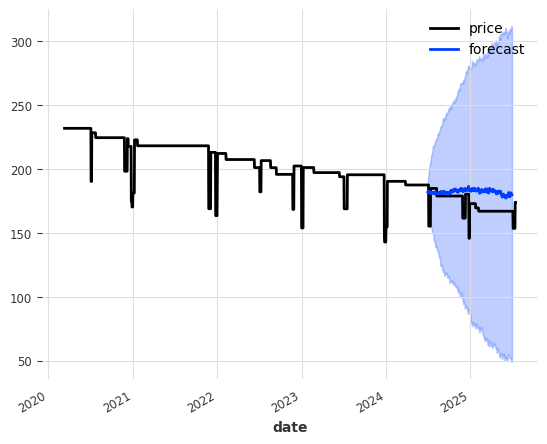

In [34]:
series.plot()
prediction.plot(label="forecast")
plt.legend()

This looks really bad...

lets try a few better models that may be more accurate!

We will start off with making sure that we can use the GPU to make things (hopefully) faster! then we will try out NBeats, since realistically when we predict if there will be a sale, we will only need to look at the next few days, no more then a month!

In [35]:
import torch
print(torch.cuda.is_available())  # Should return True

True


In [44]:
from darts.models import NBEATSModel

#input_chunk_length=365, will look at the most recent year (the length of the training data) to predict the next month (output_chunk_length=7) 

model = NBEATSModel(input_chunk_length=365, output_chunk_length=30, n_epochs=50,
    random_state=42,
    pl_trainer_kwargs={
        "accelerator": "gpu",  # or "cuda"
        "devices": 1  # Use 1 GPU
    })
#model.fit(train)
# prediction = model.predict(len(val), num_samples=1000)

In [45]:
model.fit(train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 8.9 M  | train
-------------------------------------------------------------
8.9 M     Trainable params
3.5 K     Non-trainable params
8.9 M     Total params
35.521    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 38/38 [00:03<00:00, 10.70it/s, train_loss=128.0] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 38/38 [00:03<00:00, 10.69it/s, train_loss=128.0]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=365, output_chunk_length=30, n_epochs=50, random_state=42, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 1})

In [46]:
forecast = model.predict(n=365)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


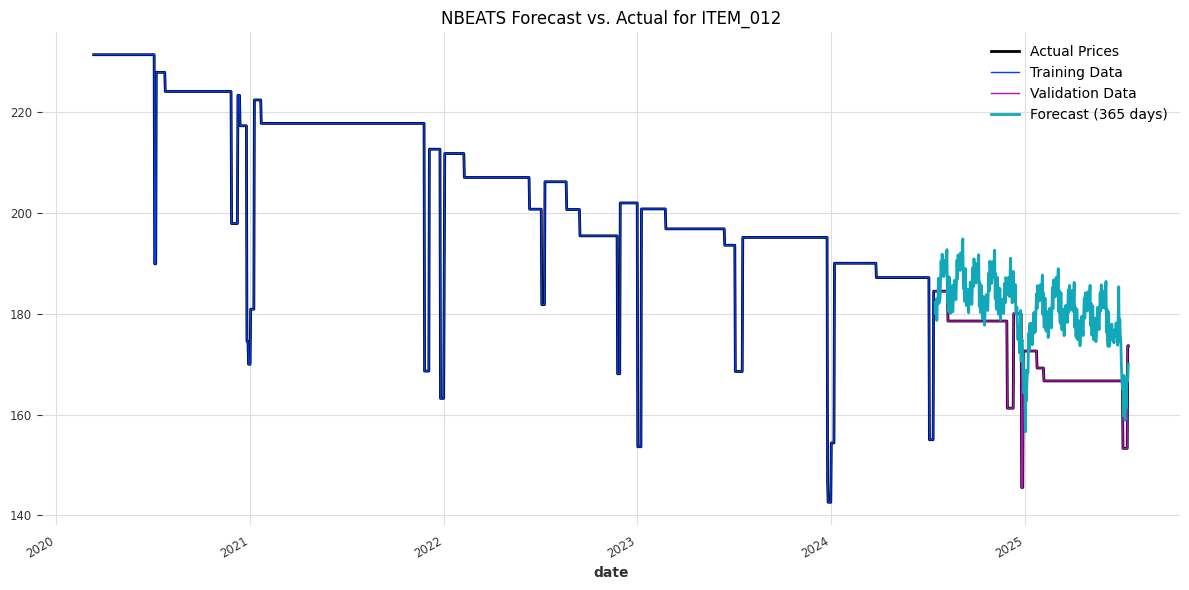

In [47]:
# Plot everything together
plt.figure(figsize=(12, 6))

# Plot the full actual series
series.plot(label="Actual Prices", lw=2)

# Overlay train and validation splits for clarity
train.plot(label="Training Data", lw=1)
val.plot(label="Validation Data", lw=1)

# Overlay the forecast
forecast.plot(label="Forecast (365 days)", lw=2)

plt.title("NBEATS Forecast vs. Actual for ITEM_012")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This seems better, but it takes a long time, even with the GPU(it saw thet there was going to be a holiday and a sale, as well as a general downward trend) but the values seem all over the place, much too jumpy! we also are getting too much information. We are not trying to predict the exact price, but rather we are trying to predict if there is a sale going to happen. Lets try with a classification model instead using a 10% spike indicator

In [ ]:
#creates a list of when items are on sale greater then a threshold
def find_spikes(series, threshold = 0.1):
    prev = None
    spikes =[]
    prices = series.values().flatten()
    for price in prices:
        if (prev == None):
            prev = price
            spikes.append(0)
        elif (price <= (prev - (prev * threshold))):
            prev = price
            spikes.append(1)
        else:
            prev = price
            spikes.append(0)
    return spikes


spikes = find_spikes(series,.1)
spike_series = TimeSeries.from_times_and_values(series.time_index, spikes)

Lets graph it to see if it works (multiply by 100 to see where it found sales)

<Axes: xlabel='date'>

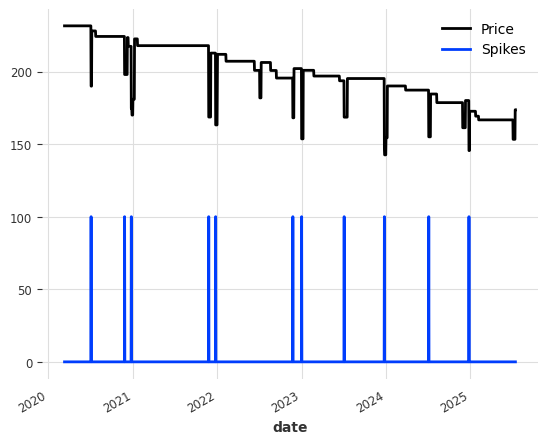

In [95]:
(series).plot(label="Price")
(spike_series*100).plot(label="Spikes")